In [1]:
from pathlib import Path
import pickle
import copy

import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.10.4+0.x64.w64.mingw32. You currently have `1.10.3+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
cwd = Path().cwd()

# Setting up the system

In [108]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=1
    ),
]

polarizations = [
    [
        couplings.polarization_Z,
        couplings.polarization_σp,
        couplings.polarization_σm,
    ],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [109]:
odepars = lindblad_julia.odeParameters(
    Ω0=hamiltonian.Γ,
    δ0=0.0,
    # polarization modulation
    Pl="sin(ωl*t+ϕl)",
    PZ0="Pl<-1/3",
    Pσp0="(Pl>=-1/3) & (Pl<=1/3)",
    Pσm0="Pl>1/3",
    ωl=2 * np.pi * 1e6,
    ϕl=0.0,
)


In [111]:
%%time
obe_system_original = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=states.QuantumSelector(J=3, electronic=states.ElectronicState.X),
    decay_channels=None,
)


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 17.3 s
Wall time: 25.4 s


In [112]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system_original, transition_selectors, odepars
)


In [110]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 1>",0.999873
"|X, J = 3>",0.000127


In [113]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X), obe_system.QN
)


# Single parameter only

In [114]:
odepars.Ω0 = hamiltonian.Γ
odepars.δ0 = 0.0 * hamiltonian.Γ
odepars.ωl = 2 * np.pi * 0.4e6
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 50e-6))
config = lindblad_julia.OBEProblemConfig(method="Tsit5()", saveat=1e-6)

results = lindblad_julia.do_simulation_single(problem, config=config)


In [115]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

qn_select_J1 = states.QuantumSelector(J=1, electronic=states.ElectronicState.X)
indices_J1 = qn_select_J1.get_indices(obe_system.QN)

qn_select_J3 = states.QuantumSelector(J=3, electronic=states.ElectronicState.X)
indices_J3 = qn_select_J3.get_indices(obe_system.QN)


23.31 photons


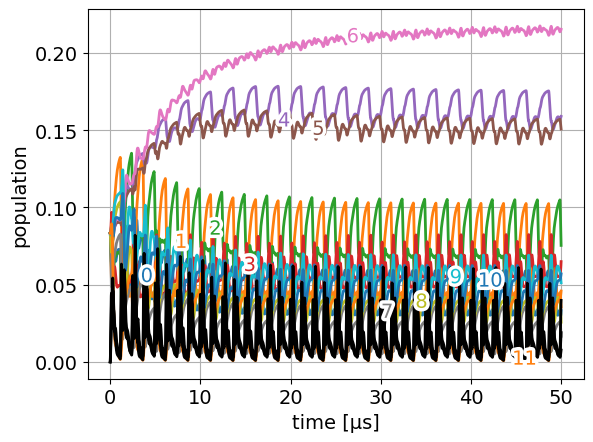

In [116]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_J1].T, lw=2, label=indices_J1)

labelLines(ax.get_lines(), align=False, fontsize=14)

ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")


In [117]:
for l in [qn.largest for idq, qn in enumerate(obe_system.QN) if idq in [1, 2, 3]]:
    print(l)


|X, J = 1, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


In [118]:
for l in [qn.largest for idq, qn in enumerate(obe_system.QN) if idq in [4, 5, 6]]:
    print(l)


|X, J = 1, F₁ = 3/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


In [119]:
for l in [
    qn.largest for idq, qn in enumerate(obe_system.QN) if idq > 6 and idq in indices_J1
]:
    print(l)


|X, J = 1, F₁ = 3/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


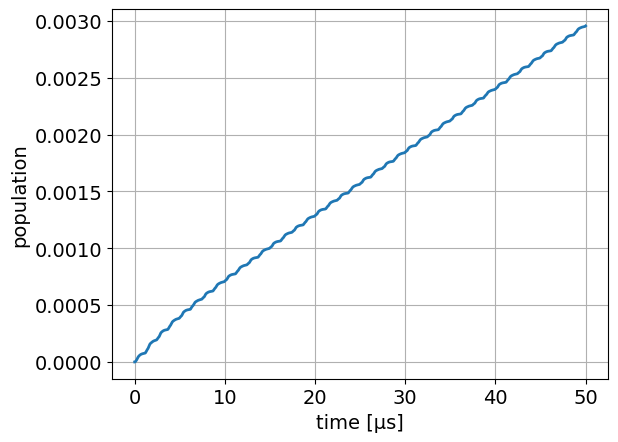

In [120]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J3].T, lw=2)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()


# Ensemble problem, scan power and pol switch frequency

In [121]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices


In [122]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")


In [123]:
rabis = np.linspace(0, 1.5 * hamiltonian.Γ, 21)
frequencies = np.linspace(0, 1 * hamiltonian.Γ, 41)


In [124]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    abstol=1e-10,
    reltol=1e-7,
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 50e-6))

scan_values = [rabis, frequencies]
parameters = ["Ω0", "ωl"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
    zipped=False,
)

lindblad_julia.setup_problem_parameter_scan(ensemble_problem)


In [125]:
%%time
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


CPU times: total: 15.6 ms
Wall time: 44 s


In [126]:
results = lindblad_julia.get_results_parameter_scan(ensemble_problem)

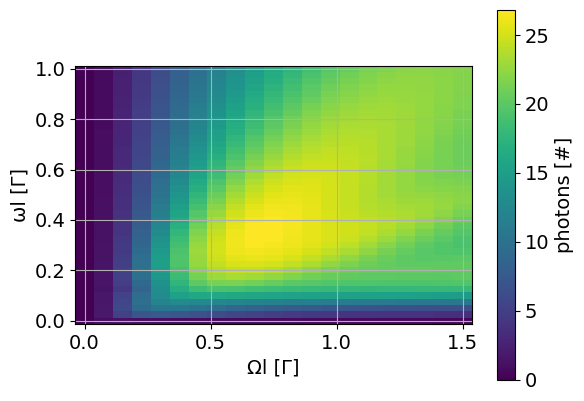

In [127]:
X, Y = np.array(results.scan_values) / (hamiltonian.Γ)
z = results.results

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, z)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("photons [#]")
ax.set_xlabel("Ωl [Γ]")
ax.set_ylabel("ωl [Γ]")
ax.set_aspect(1.0)
ax.grid()
